# [Hands-On] Word2Vec을 활용한 단어 벡터 분석

- Author: Sangkeun Jung (hugmanskj@gmail.com)

> 교육 목적

**Copyright**: All rights reserved

---

## 개요

Google의 사전학습된 Word2Vec 모델을 사용하여 단어의 의미 관계를 분석합니다.

**사용 모델**:
- Section 1-8: Google News Word2Vec (영어, 300차원, 3백만 단어)
- Section 9: 한국어 의료 판독문은 TF-IDF 기반 문서 유사도

**실습 내용**:
1. 단어 벡터 변환 및 유사도 분석 (영어)
2. 단어 유추 실험 (king - man + woman = queen)
3. t-SNE를 통한 단어 공간 시각화
4. 의미적으로 유사한 단어들의 군집화
5. **한국어 의료 판독문 데이터로 유사 환자 찾기**

---

## 1. 환경 설정 및 데이터 다운로드

In [6]:
# Colab 환경 체크
import os
import sys

# Colab 환경인지 확인
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Google Colab 환경 감지")

    # 의료 판독문 데이터 다운로드
    if not os.path.exists('medical_reports.tsv'):
        print("데이터 파일 다운로드 중...")
        url = "https://www.dropbox.com/scl/fi/pxgyowomz59q8xdyk8x29/medical_reports.tsv?rlkey=4gcd8ffm53tpoyzicgry4pyqb&st=mq3c2w38&dl=1"
        !wget -O medical_reports.tsv "{url}"
        print("✓ 데이터 다운로드 완료!")
    else:
        print("✓ 데이터 파일이 이미 존재합니다.")

    # 한글 폰트 설정
    print("\n한글 폰트 설정 중...")
    !wget -q -O NanumGothic.ttf "https://www.dropbox.com/scl/fi/uehvji0snykblsv66erj2/NanumGothic.ttf?rlkey=c4et2h36iisxdp7dsjma6qluw&dl=1"

    import warnings
    import matplotlib as mpl
    import matplotlib.font_manager as fm

    path = "NanumGothic.ttf"
    if os.path.exists(path) and os.path.getsize(path) > 100_000:
        fm.fontManager.addfont(path)
        family_name = fm.FontProperties(fname=path).get_name()
        mpl.rcParams["font.family"] = family_name
    mpl.rcParams["axes.unicode_minus"] = False
    warnings.filterwarnings("ignore")

    print("✓ 한글 폰트 설정 완료!")

else:
    print("로컬 환경에서 실행 중")

로컬 환경에서 실행 중


## 2. 라이브러리 로드

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Gensim (Word2Vec 라이브러리)
try:
    import gensim.downloader as api
    from gensim.models import KeyedVectors
    print("✓ Gensim 라이브러리 로드 완료")
except ImportError:
    print("⚠️  Gensim 설치 필요: pip install gensim")
    if IN_COLAB:
        !pip install -q gensim
        import gensim.downloader as api
        from gensim.models import KeyedVectors
        print("✓ Gensim 설치 및 로드 완료")

# 한글 폰트 설정
if IN_COLAB:
    plt.rcParams['font.family'] = 'NanumGothic'
else:
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        print("⚠ 한글 폰트가 없어 기본 폰트를 사용합니다.")

plt.rcParams['axes.unicode_minus'] = False

print("✓ 라이브러리 로드 완료!")

✓ Gensim 라이브러리 로드 완료
✓ 라이브러리 로드 완료!


In [8]:
# !pip install -q gensim

## 3. Word2Vec 모델 로드 (영어)

In [9]:
print("=" * 70)
print("Word2Vec 모델 로드 (영어)")
print("=" * 70)

print("\n⚠️  최초 실행 시 모델 다운로드에 수 분이 걸립니다 (약 1.5GB)")
print("Google News 코퍼스로 학습된 모델입니다.")
print("- 어휘 크기: 약 3백만 단어")
print("- 벡터 차원: 300차원")
print("- 학습 방법: Skip-gram with Negative Sampling")
print("\n💡 이 모델은 Section 1-8의 영어 예제에만 사용됩니다.")
print("   Section 9의 한국어 판독문은 TF-IDF 기반 방식을 사용합니다.\n")

# 모델 로드
print("모델 로딩 중...")
try:
    # gensim-data를 통해 다운로드 및 로드
    model = api.load("word2vec-google-news-300")
    print("\n✓ 모델 로드 완료!")
    print(f"✓ 어휘 크기: {len(model)} 단어")
    print(f"✓ 벡터 차원: {model.vector_size}차원")
except Exception as e:
    print(f"\n⚠️  모델 로드 실패: {e}")
    print("대안으로 소규모 모델을 사용합니다.")
    model = api.load("glove-wiki-gigaword-100")
    print(f"\n✓ GloVe 모델 로드 완료 (대체)")
    print(f"✓ 어휘 크기: {len(model)} 단어")
    print(f"✓ 벡터 차원: {model.vector_size}차원")

Word2Vec 모델 로드 (영어)

⚠️  최초 실행 시 모델 다운로드에 수 분이 걸립니다 (약 1.5GB)
Google News 코퍼스로 학습된 모델입니다.
- 어휘 크기: 약 3백만 단어
- 벡터 차원: 300차원
- 학습 방법: Skip-gram with Negative Sampling

💡 이 모델은 Section 1-8의 영어 예제에만 사용됩니다.
   Section 9의 한국어 판독문은 TF-IDF 기반 방식을 사용합니다.

모델 로딩 중...

✓ 모델 로드 완료!
✓ 어휘 크기: 3000000 단어
✓ 벡터 차원: 300차원


## 4. 단어 벡터 기본 조작

### 4.1 단어를 벡터로 변환

**분석 아이디어**:
- Word2Vec는 각 단어를 고정된 길이의 실수 벡터로 표현합니다
- 의미가 비슷한 단어들은 벡터 공간에서 가까이 위치합니다
- 벡터 연산을 통해 단어 간의 관계를 수학적으로 표현할 수 있습니다

**접근 방법**:
1. 모델에서 단어의 벡터 추출
2. 벡터의 차원과 값 확인
3. 여러 단어들의 벡터 비교

In [10]:
print("=" * 70)
print("단어를 벡터로 변환")
print("=" * 70)

# 예시 단어들
sample_words = ['king', 'queen', 'man', 'woman', 'doctor', 'hospital']

print("\n단어별 벡터 정보:\n")
for word in sample_words:
    if word in model:
        vector = model[word]
        print(f"'{word}':")
        print(f"  벡터 차원: {len(vector)}")
        print(f"  벡터 값 (처음 10개): {vector[:10]}")
        print(f"  벡터 크기(norm): {np.linalg.norm(vector):.4f}")
        print()
    else:
        print(f"'{word}': 모델에 없는 단어입니다.\n")

단어를 벡터로 변환

단어별 벡터 정보:

'king':
  벡터 차원: 300
  벡터 값 (처음 10개): [ 0.12597656  0.02978516  0.00860596  0.13964844 -0.02563477 -0.03613281
  0.11181641 -0.19824219  0.05126953  0.36328125]
  벡터 크기(norm): 2.9023

'queen':
  벡터 차원: 300
  벡터 값 (처음 10개): [ 0.00524902 -0.14355469 -0.06933594  0.12353516  0.13183594 -0.08886719
 -0.07128906 -0.21679688 -0.19726562  0.05566406]
  벡터 크기(norm): 3.0283

'man':
  벡터 차원: 300
  벡터 값 (처음 10개): [ 0.32617188  0.13085938  0.03466797 -0.08300781  0.08984375 -0.04125977
 -0.19824219  0.00689697  0.14355469  0.0019455 ]
  벡터 크기(norm): 2.3106

'woman':
  벡터 차원: 300
  벡터 값 (처음 10개): [ 0.24316406 -0.07714844 -0.10302734 -0.10742188  0.11816406 -0.10742188
 -0.11425781  0.02563477  0.11181641  0.04858398]
  벡터 크기(norm): 2.6556

'doctor':
  벡터 차원: 300
  벡터 값 (처음 10개): [-0.09326172  0.02734375  0.07958984 -0.01287842 -0.11181641  0.3359375
 -0.13867188 -0.12011719  0.02685547 -0.20410156]
  벡터 크기(norm): 2.9345

'hospital':
  벡터 차원: 300
  벡터 값 (처음 10개): [-0.09765625

### 4.2 단어 유사도 계산

**분석 아이디어**:
- 두 단어 벡터 간의 코사인 유사도로 의미적 유사성을 측정합니다
- 유사도 1에 가까울수록 의미가 비슷하고, 0에 가까울수록 관련이 없습니다
- 음수 값은 반대되는 의미를 나타낼 수 있습니다

**접근 방법**:
1. 두 단어의 벡터를 추출
2. 코사인 유사도 계산 (내적 / (크기의 곱))
3. 여러 단어 쌍에 대해 유사도 비교

In [11]:
print("=" * 70)
print("단어 유사도 계산")
print("=" * 70)

def calculate_similarity(word1, word2, model):
    """두 단어 간의 유사도 계산"""
    if word1 not in model or word2 not in model:
        return None

    # gensim의 내장 유사도 계산 함수 사용
    similarity = model.similarity(word1, word2)
    return similarity

# 유사도 테스트 단어 쌍들
word_pairs = [
    ('king', 'queen'),
    ('king', 'man'),
    ('man', 'woman'),
    ('doctor', 'hospital'),
    ('doctor', 'nurse'),
    ('car', 'automobile'),
    ('python', 'snake'),
    ('king', 'car'),  # 관련 없는 단어
]

print("\n단어 쌍별 유사도:\n")
similarities = []
for word1, word2 in word_pairs:
    sim = calculate_similarity(word1, word2, model)
    if sim is not None:
        similarities.append({'단어1': word1, '단어2': word2, '유사도': sim})
        print(f"'{word1}' ↔ '{word2}': {sim:.4f}")
    else:
        print(f"'{word1}' ↔ '{word2}': 계산 불가 (단어 없음)")

# 유사도를 데이터프레임으로 정리
sim_df = pd.DataFrame(similarities)

단어 유사도 계산

단어 쌍별 유사도:

'king' ↔ 'queen': 0.6511
'king' ↔ 'man': 0.2294
'man' ↔ 'woman': 0.7664
'doctor' ↔ 'hospital': 0.5143
'doctor' ↔ 'nurse': 0.6320
'car' ↔ 'automobile': 0.5838
'python' ↔ 'snake': 0.6606
'king' ↔ 'car': 0.0619


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

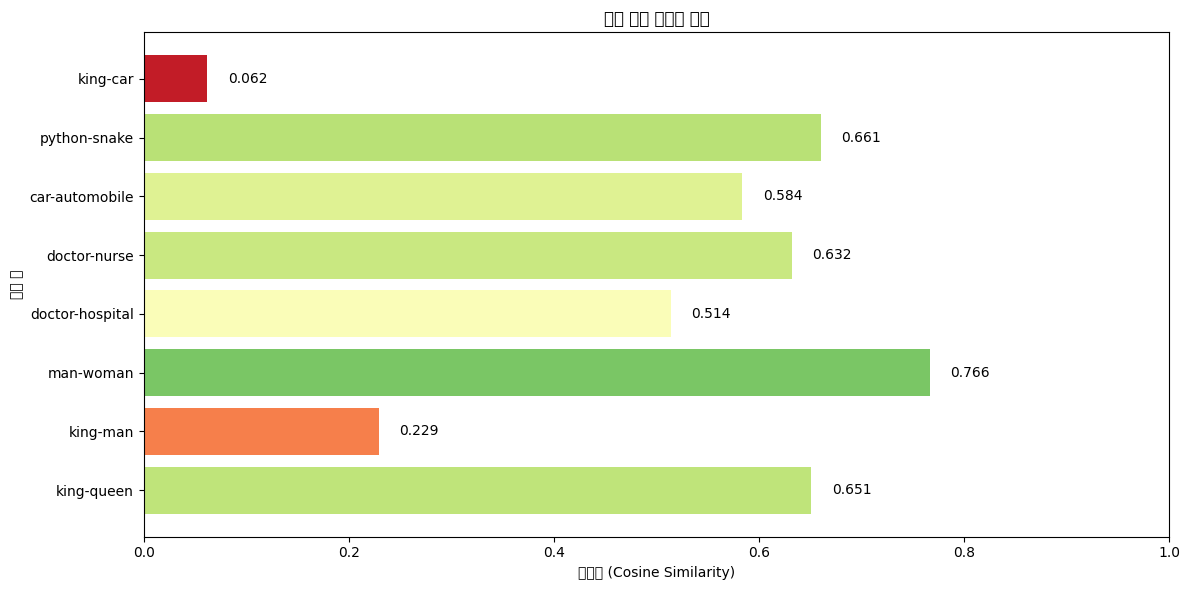

In [12]:
# 시각화
if len(sim_df) > 0:
    plt.figure(figsize=(12, 6))

    # 단어 쌍 레이블 생성
    labels = [f"{row['단어1']}-{row['단어2']}" for _, row in sim_df.iterrows()]
    values = sim_df['유사도'].values

    # 색상: 유사도가 높을수록 진한 색
    colors = plt.cm.RdYlGn(values)

    bars = plt.barh(labels, values, color=colors)
    plt.xlabel('유사도 (Cosine Similarity)')
    plt.ylabel('단어 쌍')
    plt.title('단어 쌍별 유사도 비교')
    plt.xlim(0, 1)

    # 값 표시
    for i, (bar, val) in enumerate(zip(bars, values)):
        plt.text(val + 0.02, i, f'{val:.3f}', va='center')

    plt.tight_layout()
    plt.show()

### 4.3 가장 유사한 단어 찾기

**분석 아이디어**:
- 특정 단어와 의미적으로 가장 가까운 단어들을 찾을 수 있습니다
- 이는 유의어 사전, 추천 시스템 등에 활용됩니다
- 벡터 공간에서 가장 가까운 이웃(nearest neighbors)을 찾는 것과 같습니다

**접근 방법**:
1. 기준 단어의 벡터 추출
2. 모든 단어 벡터와의 유사도 계산
3. 유사도 상위 N개 단어 반환

In [13]:
print("=" * 70)
print("가장 유사한 단어 찾기")
print("=" * 70)

def find_most_similar(word, model, top_n=10):
    """특정 단어와 가장 유사한 단어들 찾기"""
    if word not in model:
        return None

    # gensim의 most_similar 함수 사용
    similar_words = model.most_similar(word, topn=top_n)
    return similar_words

# 테스트 단어들
test_words = ['king', 'doctor', 'python', 'love', 'terrible']

print("\n각 단어와 가장 유사한 단어들 (상위 10개):\n")

for word in test_words:
    print(f"\n'{word}'와 유사한 단어들:")
    print("-" * 50)

    similar = find_most_similar(word, model, top_n=10)

    if similar:
        for i, (similar_word, similarity) in enumerate(similar, 1):
            print(f"  {i:2d}. {similar_word:20s} (유사도: {similarity:.4f})")
    else:
        print(f"  '{word}'는 모델에 없는 단어입니다.")

가장 유사한 단어 찾기

각 단어와 가장 유사한 단어들 (상위 10개):


'king'와 유사한 단어들:
--------------------------------------------------
   1. kings                (유사도: 0.7138)
   2. queen                (유사도: 0.6511)
   3. monarch              (유사도: 0.6413)
   4. crown_prince         (유사도: 0.6204)
   5. prince               (유사도: 0.6160)
   6. sultan               (유사도: 0.5865)
   7. ruler                (유사도: 0.5798)
   8. princes              (유사도: 0.5647)
   9. Prince_Paras         (유사도: 0.5433)
  10. throne               (유사도: 0.5422)

'doctor'와 유사한 단어들:
--------------------------------------------------
   1. physician            (유사도: 0.7806)
   2. doctors              (유사도: 0.7477)
   3. gynecologist         (유사도: 0.6948)
   4. surgeon              (유사도: 0.6793)
   5. dentist              (유사도: 0.6785)
   6. pediatrician         (유사도: 0.6643)
   7. pharmacist           (유사도: 0.6535)
   8. neurologist          (유사도: 0.6518)
   9. cardiologist         (유사도: 0.6352)
  10. nurse                (유사도: 0.6320

## 5. 단어 유추 (Word Analogy)

### 5.1 벡터 연산으로 단어 관계 표현

**분석 아이디어**:
- Word2Vec의 핵심 특징: 벡터 연산으로 의미 관계를 표현할 수 있습니다
- 예: "king - man + woman ≈ queen"
- 이는 "king과 man의 관계"가 "queen과 woman의 관계"와 유사하다는 의미입니다
- 벡터 공간에서 의미의 방향성이 보존됩니다

**접근 방법**:
1. 세 단어의 벡터를 가져옴: A, B, C
2. 벡터 연산: A - B + C
3. 결과 벡터와 가장 가까운 단어 찾기

In [14]:
print("=" * 70)
print("단어 유추 (Word Analogy)")
print("=" * 70)

def word_analogy(word_a, word_b, word_c, model, top_n=5):
    """
    word_a - word_b + word_c ≈ ?

    예: king - man + woman ≈ queen
    """
    if word_a not in model or word_b not in model or word_c not in model:
        return None

    # gensim의 most_similar 함수 사용
    # positive: 더하는 벡터들
    # negative: 빼는 벡터
    results = model.most_similar(
        positive=[word_a, word_c],
        negative=[word_b],
        topn=top_n
    )

    return results

# 유명한 예제들
print("\n단어 유추 실험:\n")

analogies = [
    ('king', 'man', 'woman', 'king - man + woman = ?'),
    ('Paris', 'France', 'Italy', 'Paris - France + Italy = ?'),
    ('good', 'better', 'bad', 'good - better + bad = ?'),
    ('slow', 'slower', 'fast', 'slow - slower + fast = ?'),
    ('brother', 'sister', 'uncle', 'brother - sister + uncle = ?'),
]

print("벡터 연산으로 단어 관계를 유추합니다:\n")

for word_a, word_b, word_c, description in analogies:
    print(f"{description}")
    print(f"  수식: '{word_a}' - '{word_b}' + '{word_c}'")

    results = word_analogy(word_a, word_b, word_c, model, top_n=5)

    if results:
        print(f"  결과:")
        for i, (word, similarity) in enumerate(results, 1):
            print(f"    {i}. {word:15s} (유사도: {similarity:.4f})")
    else:
        print(f"  ⚠️  단어를 찾을 수 없습니다.")
    print()

단어 유추 (Word Analogy)

단어 유추 실험:

벡터 연산으로 단어 관계를 유추합니다:

king - man + woman = ?
  수식: 'king' - 'man' + 'woman'
  결과:
    1. queen           (유사도: 0.7118)
    2. monarch         (유사도: 0.6190)
    3. princess        (유사도: 0.5902)
    4. crown_prince    (유사도: 0.5499)
    5. prince          (유사도: 0.5377)

Paris - France + Italy = ?
  수식: 'Paris' - 'France' + 'Italy'
  결과:
    1. Milan           (유사도: 0.7222)
    2. Rome            (유사도: 0.7028)
    3. Palermo_Sicily  (유사도: 0.5968)
    4. Italian         (유사도: 0.5911)
    5. Tuscany         (유사도: 0.5633)

good - better + bad = ?
  수식: 'good' - 'better' + 'bad'
  결과:
    1. terrible        (유사도: 0.5921)
    2. horrible        (유사도: 0.5700)
    3. Bad             (유사도: 0.5503)
    4. lousy           (유사도: 0.5231)
    5. nasty           (유사도: 0.4753)

slow - slower + fast = ?
  수식: 'slow' - 'slower' + 'fast'
  결과:
    1. quick           (유사도: 0.5376)
    2. quickly         (유사도: 0.4764)
    3. Slow            (유사도: 0.4761)
    4. rapidly       

### 5.2 다양한 관계 탐색

**분석 아이디어**:
- 벡터 연산은 다양한 의미 관계를 탐색할 수 있습니다
- 성별 관계: king-man+woman=queen
- 지리적 관계: Paris-France+Italy=Rome
- 문법적 관계: good-better+bad=worse
- 직업/도구 관계: painter-paint+write=writer

**접근 방법**:
1. 관계 유형별로 단어 쌍 준비
2. 벡터 연산 수행
3. 결과의 의미 해석

In [15]:
print("=" * 70)
print("다양한 관계 탐색")
print("=" * 70)

relationship_tests = {
    '성별 관계': [
        ('king', 'man', 'woman'),
        ('actor', 'man', 'woman'),
        ('brother', 'man', 'woman'),
    ],
    '수도-국가 관계': [
        ('Paris', 'France', 'Germany'),
        ('Tokyo', 'Japan', 'China'),
        ('London', 'England', 'France'),
    ],
    '형용사 비교급': [
        ('big', 'bigger', 'small'),
        ('good', 'better', 'bad'),
        ('old', 'older', 'young'),
    ],
    '동사-명사 관계': [
        ('write', 'writer', 'paint'),
        ('teach', 'teacher', 'sing'),
        ('swim', 'swimmer', 'run'),
    ],
}

print("\n관계 유형별 벡터 연산 결과:\n")

for relationship, test_cases in relationship_tests.items():
    print(f"\n[{relationship}]")
    print("=" * 60)

    for word_a, word_b, word_c in test_cases:
        results = word_analogy(word_a, word_b, word_c, model, top_n=3)

        if results:
            top_result = results[0][0]
            similarity = results[0][1]
            print(f"  {word_a} - {word_b} + {word_c} → {top_result} (유사도: {similarity:.3f})")
        else:
            print(f"  {word_a} - {word_b} + {word_c} → 계산 불가")

다양한 관계 탐색

관계 유형별 벡터 연산 결과:


[성별 관계]
  king - man + woman → queen (유사도: 0.712)
  actor - man + woman → actress (유사도: 0.860)
  brother - man + woman → sister (유사도: 0.810)

[수도-국가 관계]
  Paris - France + Germany → Berlin (유사도: 0.764)
  Tokyo - Japan + China → Beijing (유사도: 0.822)
  London - England + France → Paris (유사도: 0.731)

[형용사 비교급]
  big - bigger + small → large (유사도: 0.624)
  good - better + bad → terrible (유사도: 0.592)
  old - older + young → yearold (유사도: 0.636)

[동사-명사 관계]
  write - writer + paint → repaint (유사도: 0.473)
  teach - teacher + sing → sing_cappella (유사도: 0.575)
  swim - swimmer + run → runs (유사도: 0.548)


## 6. 단어 벡터 시각화 (t-SNE)

### 6.1 t-SNE로 차원 축소

**분석 아이디어**:
- Word2Vec는 300차원의 고차원 벡터입니다
- 사람이 이해하기 위해 2차원 또는 3차원으로 축소해야 합니다
- t-SNE는 고차원 데이터의 구조를 보존하면서 저차원으로 투영합니다
- 유사한 단어들이 가까이 모이는 것을 시각적으로 확인할 수 있습니다

**접근 방법**:
1. 분석할 단어 선정 (관련된 단어 그룹들)
2. 각 단어의 300차원 벡터 추출
3. t-SNE로 2차원으로 축소
4. 2차원 평면에 단어들을 점으로 표시

In [16]:
print("=" * 70)
print("t-SNE로 단어 벡터 시각화")
print("=" * 70)

# 시각화할 단어 그룹 선정
word_groups = {
    '왕족': ['king', 'queen', 'prince', 'princess', 'monarch', 'royal', 'throne', 'crown'],
    '직업': ['doctor', 'nurse', 'teacher', 'engineer', 'lawyer', 'chef', 'artist', 'musician'],
    '동물': ['dog', 'cat', 'lion', 'tiger', 'elephant', 'monkey', 'bird', 'fish'],
    '색상': ['red', 'blue', 'green', 'yellow', 'black', 'white', 'purple', 'orange'],
    '국가': ['USA', 'China', 'Japan', 'Germany', 'France', 'Korea', 'Italy', 'Spain'],
    '감정': ['happy', 'sad', 'angry', 'excited', 'nervous', 'calm', 'surprised', 'afraid'],
}

# 모델에 있는 단어만 필터링
filtered_words = []
word_labels = []
word_colors = []

color_map = {
    '왕족': 'red',
    '직업': 'blue',
    '동물': 'green',
    '색상': 'orange',
    '국가': 'purple',
    '감정': 'brown',
}

for group, words in word_groups.items():
    for word in words:
        if word in model:
            filtered_words.append(word)
            word_labels.append(f"{word}")
            word_colors.append(color_map[group])

print(f"\n시각화할 단어: {len(filtered_words)}개")
print(f"그룹: {list(word_groups.keys())}\n")

# 벡터 추출
print("단어 벡터 추출 중...")
word_vectors = np.array([model[word] for word in filtered_words])
print(f"벡터 형태: {word_vectors.shape} (단어 수 × 차원)")

# t-SNE로 차원 축소 (300차원 → 2차원)
print("\nt-SNE로 차원 축소 중... (시간이 걸릴 수 있습니다)")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
word_vectors_2d = tsne.fit_transform(word_vectors)
print(f"축소 완료: {word_vectors_2d.shape} (단어 수 × 2차원)")

t-SNE로 단어 벡터 시각화

시각화할 단어: 48개
그룹: ['왕족', '직업', '동물', '색상', '국가', '감정']

단어 벡터 추출 중...
벡터 형태: (48, 300) (단어 수 × 차원)

t-SNE로 차원 축소 중... (시간이 걸릴 수 있습니다)
축소 완료: (48, 2) (단어 수 × 2차원)


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon


시각화 생성 중...


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

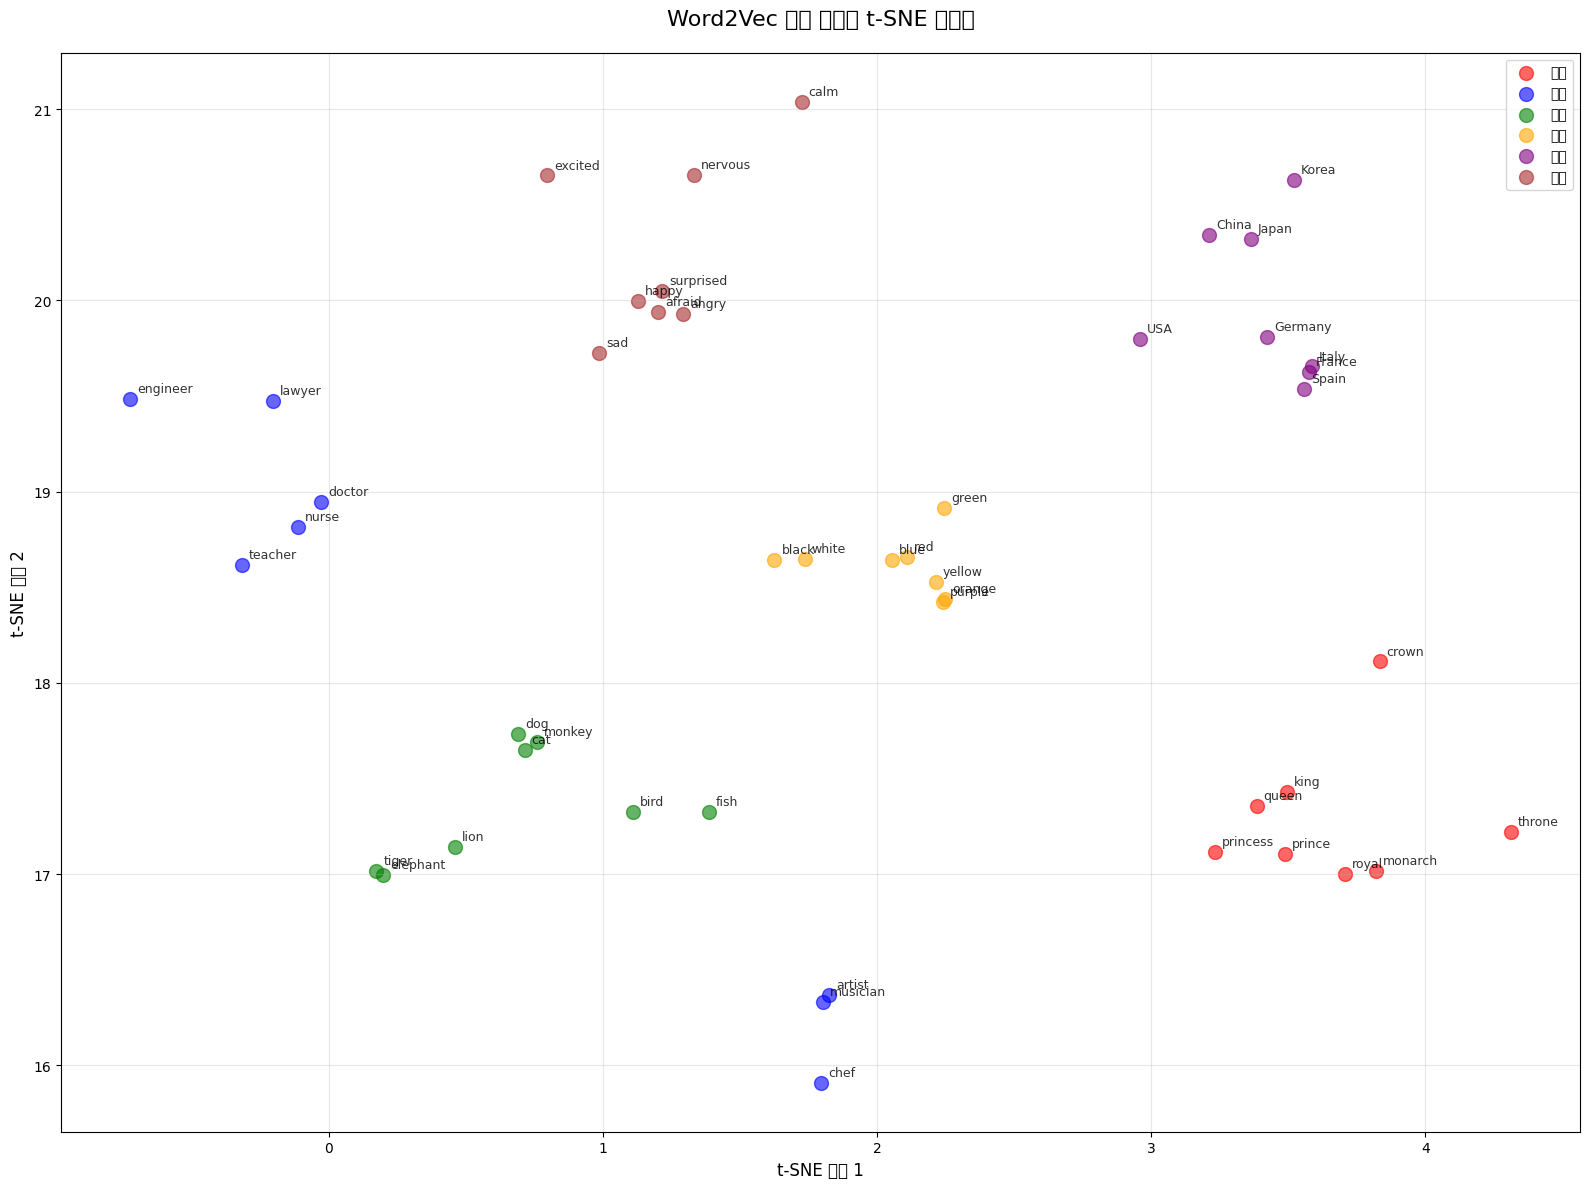


✓ 시각화 완료!

💡 해석:
  - 의미가 비슷한 단어들이 가까이 모여있습니다
  - 같은 카테고리의 단어들이 군집을 이룹니다
  - 벡터 공간에서 의미의 구조가 보존됩니다


In [17]:
# 시각화
print("\n시각화 생성 중...")

plt.figure(figsize=(16, 12))

# 그룹별로 플롯
for group, color in color_map.items():
    # 해당 그룹의 인덱스 찾기
    indices = [i for i, word in enumerate(filtered_words)
               if word in word_groups[group]]

    if indices:
        x = word_vectors_2d[indices, 0]
        y = word_vectors_2d[indices, 1]
        plt.scatter(x, y, c=color, label=group, s=100, alpha=0.6)

# 단어 레이블 추가
for i, word in enumerate(filtered_words):
    plt.annotate(word,
                xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9,
                alpha=0.8)

plt.title('Word2Vec 단어 벡터의 t-SNE 시각화', fontsize=16, pad=20)
plt.xlabel('t-SNE 차원 1', fontsize=12)
plt.ylabel('t-SNE 차원 2', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ 시각화 완료!")
print("\n💡 해석:")
print("  - 의미가 비슷한 단어들이 가까이 모여있습니다")
print("  - 같은 카테고리의 단어들이 군집을 이룹니다")
print("  - 벡터 공간에서 의미의 구조가 보존됩니다")

### 6.2 특정 주제 집중 시각화

**분석 아이디어**:
- 특정 주제에 집중해서 더 자세히 살펴볼 수 있습니다
- 예: 직업 관련 단어들의 미세한 관계
- 더 많은 단어를 포함시켜 풍부한 분석 가능

**접근 방법**:
1. 관심 주제 선정 (예: 의료)
2. 관련 단어 확장 (유사 단어 포함)
3. t-SNE로 시각화

In [18]:
print("=" * 70)
print("특정 주제 집중 시각화: 의료 분야")
print("=" * 70)

# 의료 관련 핵심 단어
medical_seeds = ['doctor', 'hospital', 'patient', 'medicine', 'disease']

# 각 단어와 유사한 단어들도 포함
medical_words = set(medical_seeds)

print("\n핵심 단어에서 확장된 단어들:\n")
for seed in medical_seeds:
    if seed in model:
        similar = model.most_similar(seed, topn=8)
        related = [word for word, _ in similar]
        medical_words.update(related)
        print(f"  {seed}: {', '.join(related[:5])}...")

medical_words = list(medical_words)
print(f"\n총 {len(medical_words)}개 단어")

# 벡터 추출
medical_vectors = np.array([model[word] for word in medical_words])

# t-SNE 축소
print("\nt-SNE 차원 축소 중...")
tsne_medical = TSNE(n_components=2, random_state=42, perplexity=15, n_iter=1000)
medical_vectors_2d = tsne_medical.fit_transform(medical_vectors)

특정 주제 집중 시각화: 의료 분야

핵심 단어에서 확장된 단어들:

  doctor: physician, doctors, gynecologist, surgeon, dentist...
  hospital: Hospital, hopsital, hosptial, hospitals, intensive_care...
  patient: patients, Patient, physicians, physician, acutely_unwell...
  medicine: medicines, medecine, allopathic_medicine, medications, medical...
  disease: diseases, infection, Disease, cancer, diease...

총 44개 단어

t-SNE 차원 축소 중...


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

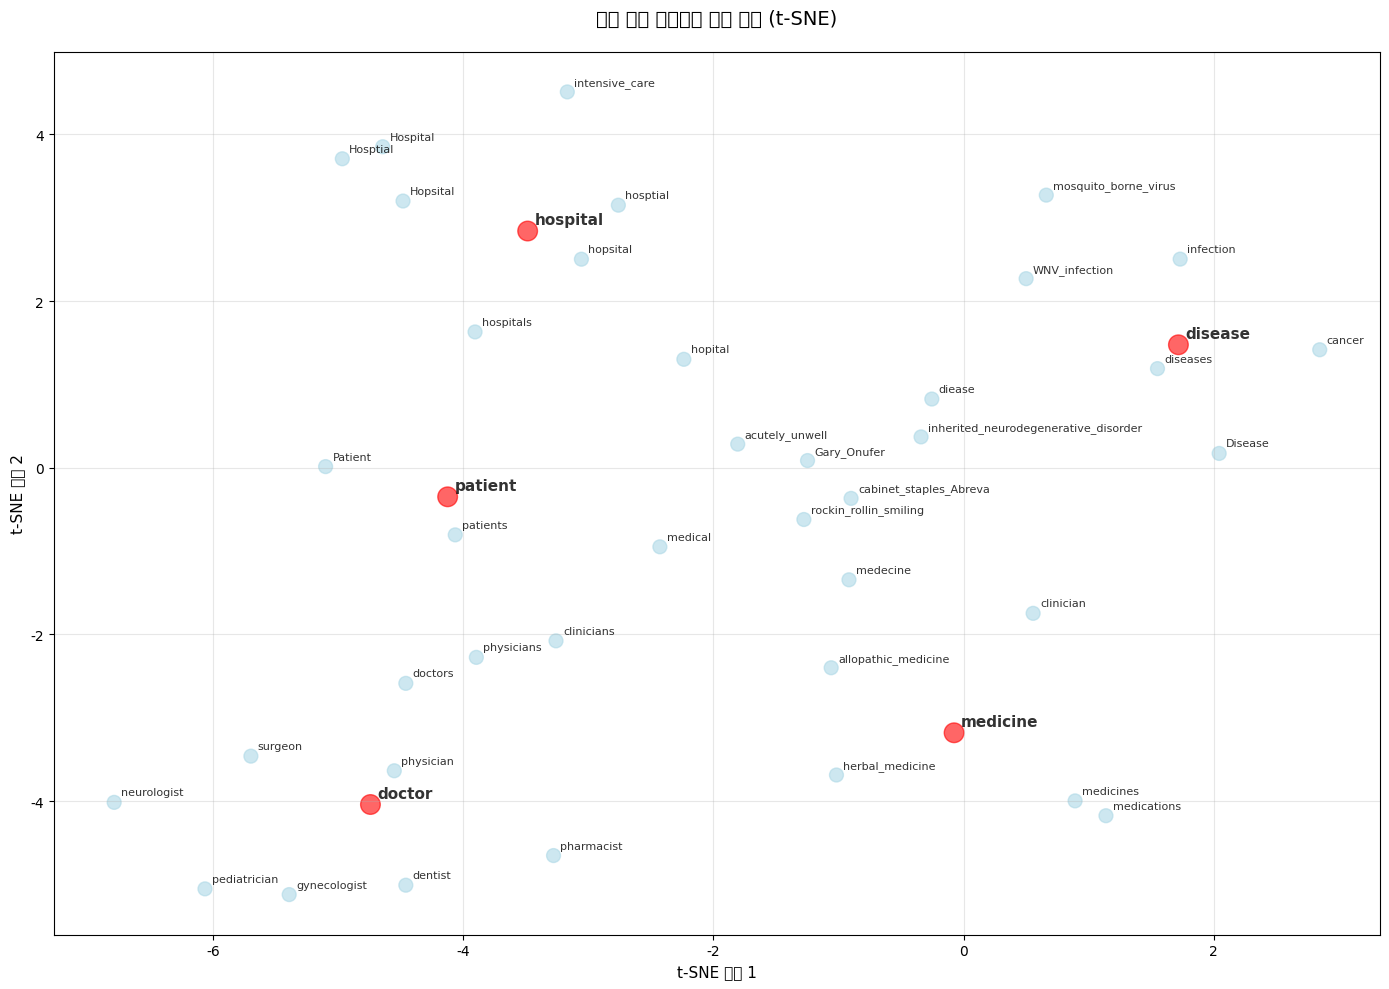


✓ 의료 분야 시각화 완료!


In [19]:
# 시각화
plt.figure(figsize=(14, 10))

# 핵심 단어와 확장 단어를 다른 색으로 표시
colors = ['red' if word in medical_seeds else 'lightblue'
          for word in medical_words]
sizes = [200 if word in medical_seeds else 100
         for word in medical_words]

plt.scatter(medical_vectors_2d[:, 0], medical_vectors_2d[:, 1],
           c=colors, s=sizes, alpha=0.6)

# 단어 레이블
for i, word in enumerate(medical_words):
    fontsize = 11 if word in medical_seeds else 8
    fontweight = 'bold' if word in medical_seeds else 'normal'

    plt.annotate(word,
                xy=(medical_vectors_2d[i, 0], medical_vectors_2d[i, 1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=fontsize,
                fontweight=fontweight,
                alpha=0.8)

plt.title('의료 분야 단어들의 벡터 공간 (t-SNE)', fontsize=14, pad=20)
plt.xlabel('t-SNE 차원 1', fontsize=11)
plt.ylabel('t-SNE 차원 2', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ 의료 분야 시각화 완료!")

### 6.3 유추 관계 시각화

**분석 아이디어**:
- "king - man + woman = queen" 같은 벡터 연산을 시각적으로 확인
- 벡터 공간에서 평행사변형 관계를 볼 수 있습니다
- 벡터의 방향성이 의미 관계를 나타냅니다

**접근 방법**:
1. 유추에 사용될 4개 단어 선정
2. t-SNE로 2차원 투영
3. 화살표로 벡터 연산 표시

In [20]:
print("=" * 70)
print("유추 관계 시각화")
print("=" * 70)

# 유추 실험: king - man + woman = queen
analogy_words = ['king', 'queen', 'man', 'woman',
                 'prince', 'princess', 'boy', 'girl',
                 'actor', 'actress', 'brother', 'sister']

# 벡터 추출
analogy_vectors = np.array([model[word] for word in analogy_words])

# PCA로 먼저 차원 축소 (t-SNE 성능 향상)
pca = PCA(n_components=min(10, len(analogy_words)))
analogy_vectors_pca = pca.fit_transform(analogy_vectors)

# t-SNE로 2차원 축소
tsne_analogy = TSNE(n_components=2, random_state=42, perplexity=5)
analogy_vectors_2d = tsne_analogy.fit_transform(analogy_vectors_pca)

유추 관계 시각화


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

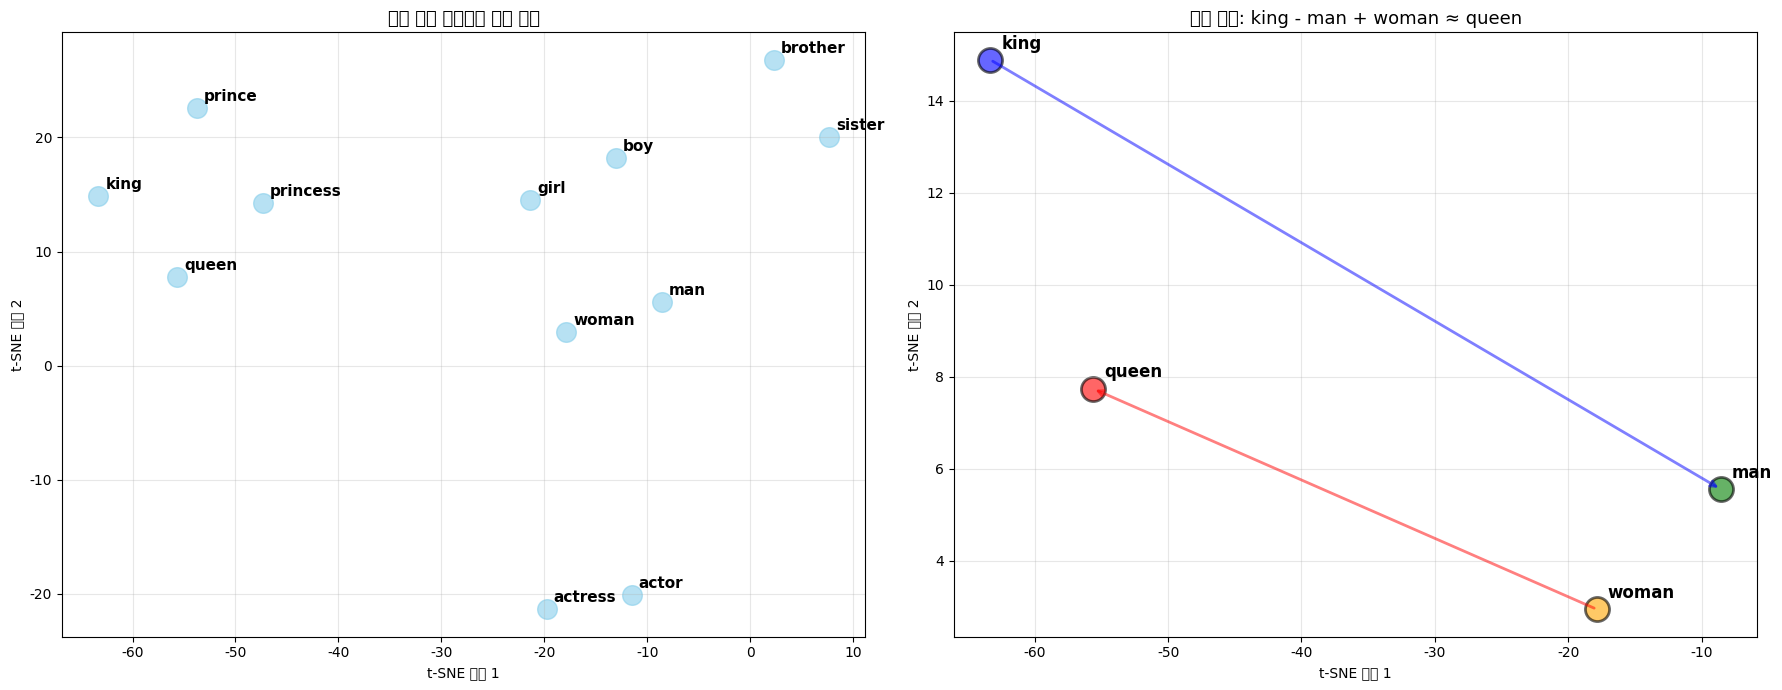


✓ 유추 관계 시각화 완료!

💡 해석:
  - 'king → man' 벡터와 'queen → woman' 벡터가 유사한 방향을 가집니다
  - 벡터 공간에서 성별 관계가 일관되게 표현됩니다


In [21]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 왼쪽: 전체 단어 표시
ax1 = axes[0]
ax1.scatter(analogy_vectors_2d[:, 0], analogy_vectors_2d[:, 1],
           s=200, c='skyblue', alpha=0.6)

for i, word in enumerate(analogy_words):
    ax1.annotate(word,
                xy=(analogy_vectors_2d[i, 0], analogy_vectors_2d[i, 1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=11,
                fontweight='bold')

ax1.set_title('성별 관련 단어들의 벡터 공간', fontsize=13)
ax1.set_xlabel('t-SNE 차원 1', fontsize=10)
ax1.set_ylabel('t-SNE 차원 2', fontsize=10)
ax1.grid(True, alpha=0.3)

# 오른쪽: king-man+woman=queen 시각화
ax2 = axes[1]

# 주요 4단어만 표시
key_words = ['king', 'queen', 'man', 'woman']
key_indices = [analogy_words.index(w) for w in key_words]
key_vectors_2d = analogy_vectors_2d[key_indices]

colors_map = {'king': 'blue', 'queen': 'red', 'man': 'green', 'woman': 'orange'}

for i, word in enumerate(key_words):
    x, y = key_vectors_2d[i]
    ax2.scatter(x, y, s=300, c=colors_map[word], alpha=0.6, edgecolors='black', linewidth=2)
    ax2.annotate(word, xy=(x, y), xytext=(8, 8),
                textcoords='offset points',
                fontsize=12, fontweight='bold')

# 벡터 화살표 그리기
king_idx = key_words.index('king')
man_idx = key_words.index('man')
woman_idx = key_words.index('woman')
queen_idx = key_words.index('queen')

ax2.annotate('', xy=key_vectors_2d[man_idx], xytext=key_vectors_2d[king_idx],
            arrowprops=dict(arrowstyle='->', color='blue', lw=2, alpha=0.5))

# woman -> queen 벡터 (평행 관계)
ax2.annotate('', xy=key_vectors_2d[queen_idx], xytext=key_vectors_2d[woman_idx],
            arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.5))

ax2.set_title('벡터 유추: king - man + woman ≈ queen', fontsize=13)
ax2.set_xlabel('t-SNE 차원 1', fontsize=10)
ax2.set_ylabel('t-SNE 차원 2', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ 유추 관계 시각화 완료!")
print("\n💡 해석:")
print("  - 'king → man' 벡터와 'queen → woman' 벡터가 유사한 방향을 가집니다")
print("  - 벡터 공간에서 성별 관계가 일관되게 표현됩니다")

---

## 7. 유사 단어 군집 분석

### 7.1 단어 군집 시각화

**분석 아이디어**:
- 특정 단어와 유사한 단어들을 모아서 의미 군집을 만들 수 있습니다
- 여러 중심 단어에 대한 유사 단어들을 동시에 보면 의미 공간의 구조를 이해할 수 있습니다
- 군집 간의 경계와 중첩을 확인할 수 있습니다

**접근 방법**:
1. 중심 단어 선정 (예: good, bad, big, small)
2. 각 중심 단어에 대해 유사 단어 추출
3. 전체를 t-SNE로 시각화
4. 중심 단어별로 다른 색상으로 표시

In [22]:
print("=" * 70)
print("유사 단어 군집 분석")
print("=" * 70)

# 중심 단어 선정
center_words = ['good', 'bad', 'big', 'small', 'fast', 'slow']

# 각 중심 단어별 유사 단어 수집
cluster_data = []
cluster_labels = []
cluster_colors_list = []

color_palette = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

print("\n중심 단어별 유사 단어 수집:\n")

for i, center in enumerate(center_words):
    if center not in model:
        continue

    # 중심 단어 추가
    cluster_data.append(model[center])
    cluster_labels.append(f"{center} (중심)")
    cluster_colors_list.append(color_palette[i])

    # 유사 단어 추가
    similar = model.most_similar(center, topn=10)
    print(f"'{center}': {', '.join([w for w, _ in similar[:5]])}...")

    for word, sim in similar:
        cluster_data.append(model[word])
        cluster_labels.append(word)
        cluster_colors_list.append(color_palette[i])

cluster_vectors = np.array(cluster_data)
print(f"\n총 {len(cluster_vectors)}개 단어")

# t-SNE 차원 축소
print("\nt-SNE 차원 축소 중...")
tsne_cluster = TSNE(n_components=2, random_state=42, perplexity=20)
cluster_vectors_2d = tsne_cluster.fit_transform(cluster_vectors)

유사 단어 군집 분석

중심 단어별 유사 단어 수집:

'good': great, bad, terrific, decent, nice...
'bad': good, terrible, horrible, Bad, lousy...
'big': huge, bigger, biggest, major, gigantic...
'small': large, tiny, medium_sized, Small, smaller...
'fast': quick, rapidly, Fast, quickly, slow...
'slow': Slow, slower, slowed, painfully_slow, slowing...

총 66개 단어

t-SNE 차원 축소 중...


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

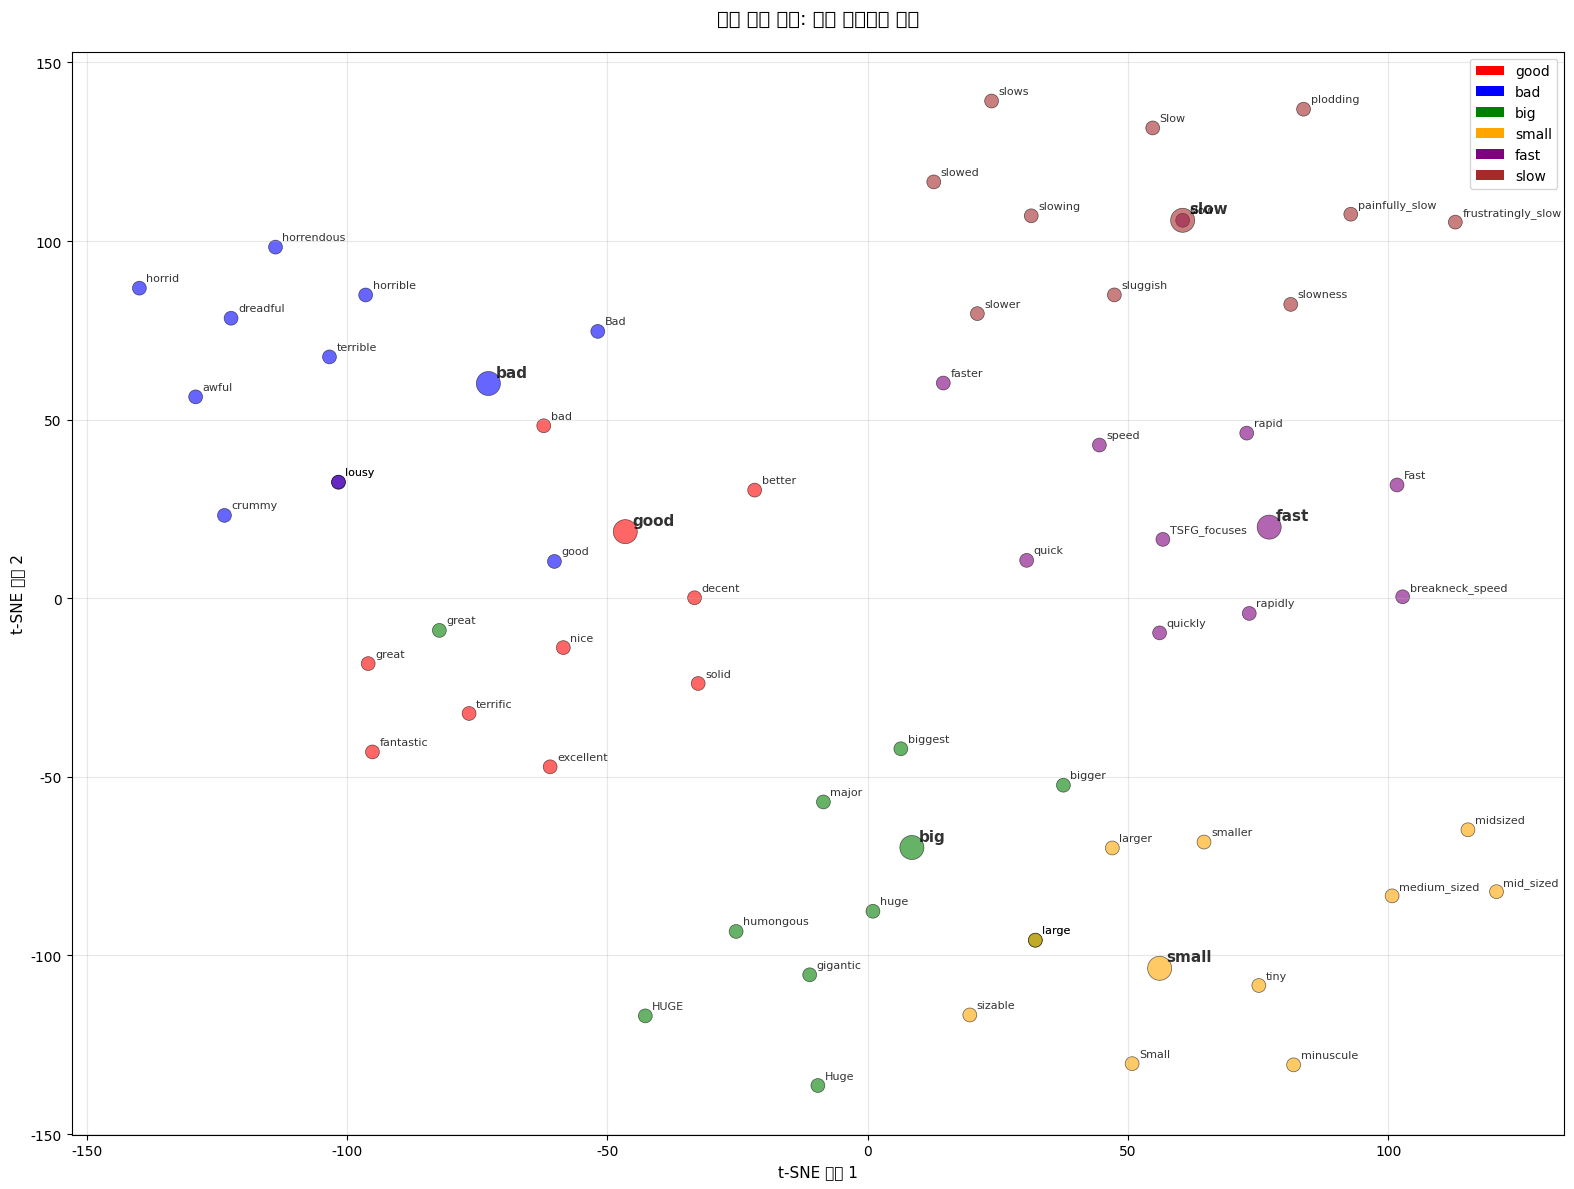


✓ 군집 분석 완료!

💡 관찰:
  - 각 중심 단어를 중심으로 유사 단어들이 모여있습니다
  - 반대 의미(good-bad, big-small)는 공간상 멀리 떨어져 있습니다
  - 일부 단어들은 여러 군집에 걸쳐 있을 수 있습니다


In [23]:
# 시각화
plt.figure(figsize=(16, 12))

# 점 크기: 중심 단어는 크게, 유사 단어는 작게
sizes = [300 if '(중심)' in label else 100 for label in cluster_labels]

plt.scatter(cluster_vectors_2d[:, 0], cluster_vectors_2d[:, 1],
           c=cluster_colors_list, s=sizes, alpha=0.6, edgecolors='black', linewidth=0.5)

# 레이블 추가
for i, label in enumerate(cluster_labels):
    fontsize = 11 if '(중심)' in label else 8
    fontweight = 'bold' if '(중심)' in label else 'normal'

    plt.annotate(label.replace(' (중심)', ''),
                xy=(cluster_vectors_2d[i, 0], cluster_vectors_2d[i, 1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=fontsize,
                fontweight=fontweight,
                alpha=0.8)

plt.title('단어 군집 분석: 유사 단어들의 분포', fontsize=14, pad=20)
plt.xlabel('t-SNE 차원 1', fontsize=11)
plt.ylabel('t-SNE 차원 2', fontsize=11)

# 범례 생성
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_palette[i], label=word)
                   for i, word in enumerate(center_words) if word in model]
plt.legend(handles=legend_elements, loc='best', fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ 군집 분석 완료!")
print("\n💡 관찰:")
print("  - 각 중심 단어를 중심으로 유사 단어들이 모여있습니다")
print("  - 반대 의미(good-bad, big-small)는 공간상 멀리 떨어져 있습니다")
print("  - 일부 단어들은 여러 군집에 걸쳐 있을 수 있습니다")

---

## 8. 실전 응용: 문서 벡터화 (영어 예제)

### 8.1 단어 벡터로 문서 표현하기

**분석 아이디어**:
- Word2Vec는 단어를 벡터로 변환하지만, 문서 전체를 표현하려면 단어 벡터들을 합쳐야 합니다
- 가장 간단한 방법: 문서 내 모든 단어 벡터의 평균
- 더 정교한 방법: TF-IDF 가중 평균 (중요한 단어에 더 큰 가중치)

**접근 방법**:
1. 문서를 단어로 토큰화
2. 각 단어의 벡터를 Word2Vec에서 가져오기
3. 평균을 계산하여 문서 벡터 생성
4. 문서 간 유사도 계산

In [24]:
print("=" * 70)
print("문서 벡터화 (영어 예제)")
print("=" * 70)

def document_to_vector(document, model):
    """
    문서를 벡터로 변환 (단어 벡터들의 평균)

    Args:
        document: 문서 텍스트 (문자열)
        model: Word2Vec 모델

    Returns:
        문서 벡터 (numpy array)
    """
    # 간단한 토큰화
    words = document.lower().split()

    # 모델에 있는 단어들의 벡터만 수집
    word_vectors = []
    for word in words:
        if word in model:
            word_vectors.append(model[word])

    if not word_vectors:
        # 모든 단어가 모델에 없으면 0 벡터 반환
        return np.zeros(model.vector_size)

    # 평균 계산
    doc_vector = np.mean(word_vectors, axis=0)
    return doc_vector

# 예제 문서들
sample_documents = [
    "The doctor examined the patient at the hospital.",
    "The king ruled his kingdom with wisdom.",
    "The chef prepared delicious food at the restaurant.",
    "The teacher taught mathematics to students.",
    "The patient needs medical treatment and care.",
]

print("\n문서들을 벡터로 변환:\n")

doc_vectors = []
for i, doc in enumerate(sample_documents, 1):
    vec = document_to_vector(doc, model)
    doc_vectors.append(vec)
    print(f"문서 {i}: {doc}")
    print(f"  벡터 크기: {len(vec)}, 첫 5개 값: {vec[:5]}")
    print()

doc_vectors = np.array(doc_vectors)

문서 벡터화 (영어 예제)

문서들을 벡터로 변환:

문서 1: The doctor examined the patient at the hospital.
  벡터 크기: 300, 첫 5개 값: [-0.04478237  0.08586775  0.04708426  0.05994524 -0.04781669]

문서 2: The king ruled his kingdom with wisdom.
  벡터 크기: 300, 첫 5개 값: [ 0.12141927  0.02832031 -0.02017212  0.02062988  0.01983643]

문서 3: The chef prepared delicious food at the restaurant.
  벡터 크기: 300, 첫 5개 값: [-0.09654018  0.00913783  0.03505162  0.11621094 -0.03768049]

문서 4: The teacher taught mathematics to students.
  벡터 크기: 300, 첫 5개 값: [ 0.18237305 -0.02996826  0.15026855  0.10394287  0.04589844]

문서 5: The patient needs medical treatment and care.
  벡터 크기: 300, 첫 5개 값: [-0.10009766  0.20263672  0.05262451  0.10742188 -0.07106934]



### 8.2 문서 간 유사도 계산

**분석 아이디어**:
- 문서 벡터를 얻었으면 문서 간 유사도를 계산할 수 있습니다
- 코사인 유사도로 의미적 유사성 측정
- 검색 시스템, 문서 분류, 추천 시스템에 활용 가능

**접근 방법**:
1. 모든 문서를 벡터로 변환
2. 문서 쌍마다 코사인 유사도 계산
3. 유사도 행렬로 시각화

In [25]:
print("=" * 70)
print("문서 간 유사도 분석 (영어)")
print("=" * 70)

# 문서 간 유사도 행렬 계산
doc_similarity_matrix = cosine_similarity(doc_vectors)

print("\n문서 간 유사도 행렬:\n")

# 데이터프레임으로 정리
doc_labels = [f"문서{i+1}" for i in range(len(sample_documents))]
sim_df = pd.DataFrame(doc_similarity_matrix,
                      index=doc_labels,
                      columns=doc_labels)

for i, doc in enumerate(sample_documents):
    print(f"문서{i+1}: {doc}")
print()
sim_df.round(3)

문서 간 유사도 분석 (영어)

문서 간 유사도 행렬:

문서1: The doctor examined the patient at the hospital.
문서2: The king ruled his kingdom with wisdom.
문서3: The chef prepared delicious food at the restaurant.
문서4: The teacher taught mathematics to students.
문서5: The patient needs medical treatment and care.



,문서1,문서2,문서3,문서4,문서5
문서1,1.000,0.392,0.374,0.257,0.698
문서2,0.392,1.000,0.249,0.204,0.240
문서3,0.374,0.249,1.000,0.253,0.228
문서4,0.257,0.204,0.253,1.000,0.168
문서5,0.698,0.240,0.228,0.168,1.000


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

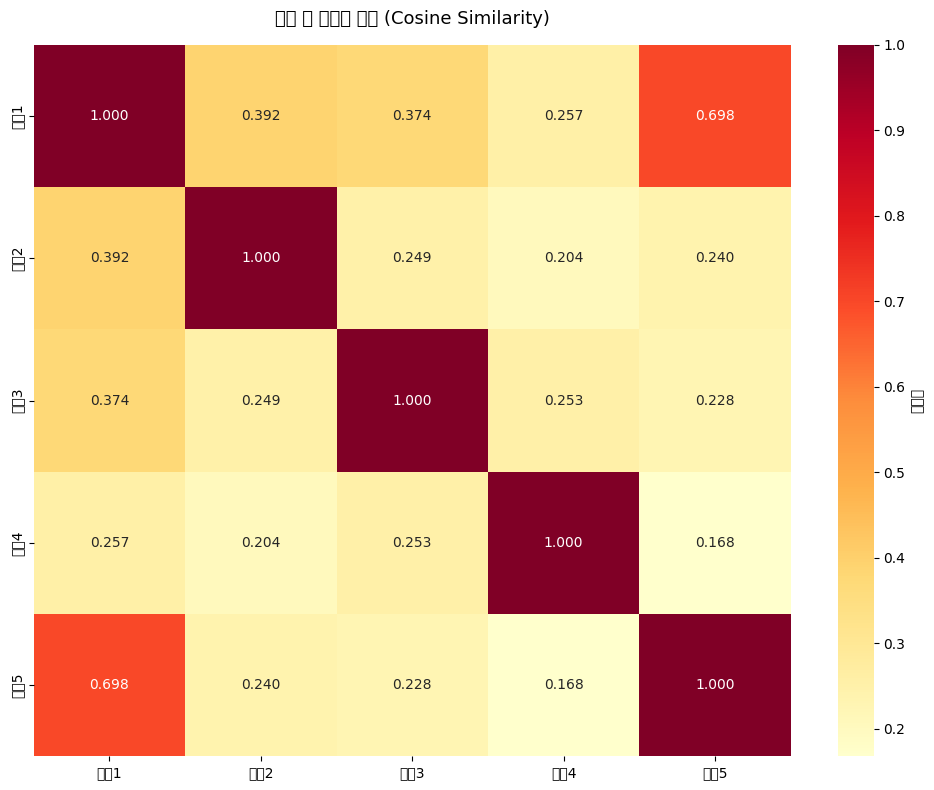


가장 유사한 문서 쌍:

문서 1 ↔ 문서 5: 0.698
  문서 1: The doctor examined the patient at the hospital.
  문서 5: The patient needs medical treatment and care.


💡 해석:
  - 문서 1과 5는 의료 관련 내용으로 유사도가 높습니다
  - 각 문서의 주제가 벡터 공간에서 잘 표현됩니다


In [26]:
# 히트맵으로 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(doc_similarity_matrix,
           annot=True,
           fmt='.3f',
           cmap='YlOrRd',
           xticklabels=doc_labels,
           yticklabels=doc_labels,
           cbar_kws={'label': '유사도'})
plt.title('문서 간 유사도 행렬 (Cosine Similarity)', fontsize=13, pad=15)
plt.tight_layout()
plt.show()

# 가장 유사한 문서 쌍 찾기
print("\n가장 유사한 문서 쌍:\n")

for i in range(len(sample_documents)):
    for j in range(i+1, len(sample_documents)):
        sim = doc_similarity_matrix[i, j]
        if sim > 0.5:  # 유사도 0.5 이상
            print(f"문서 {i+1} ↔ 문서 {j+1}: {sim:.3f}")
            print(f"  문서 {i+1}: {sample_documents[i]}")
            print(f"  문서 {j+1}: {sample_documents[j]}")
            print()

print("\n💡 해석:")
print("  - 문서 1과 5는 의료 관련 내용으로 유사도가 높습니다")
print("  - 각 문서의 주제가 벡터 공간에서 잘 표현됩니다")

## 9. 한국어 의료 판독문 데이터 분석 (TF-IDF 기반)

**[중요] Word2Vec 모델의 한계 및 한국어 처리 방안:**

이전 Section들에서는 Google News 코퍼스로 훈련된 영어 Word2Vec 모델을 활용하여 단어 및 문서 벡터 분석을 진행했습니다. 이 모델은 영어 텍스트에 대해서는 뛰어난 성능을 보이지만, **한국어 텍스트에는 직접 적용하기 어렵습니다.**

Word2Vec과 같은 전통적인 Word Embedding 기술은 특정 언어의 대규모 코퍼스로 훈련되므로, 해당 언어의 문맥과 의미를 잘 학습합니다. 하지만 언어가 바뀌면 모델을 새로 훈련하거나, 해당 언어에 맞춰 전처리(형태소 분석 등)를 진행해야 합니다.


**추후 더 고도화된 한국어 Word/Token Embedding 실습:**

이 실습 이후, 한국어 텍스트 분석을 위한 더 고도화된 Word Embedding (예: FastText, Word2Vec for Korean) 또는 Token Embedding (예: BERT, GPT 등 최신 Transformer 기반 모델) 기술을 활용한 실습이 제공될 예정입니다. 이를 통해 한국어의 특성(교착어, 형태소 등)을 고려한 정교한 텍스트 분석 방법을 학습할 수 있습니다.

## 10. Summary

### 📚 학습한 주요 개념:

1. Word2Vec 기본 (영어, Section 1-8)
   - 단어를 고정 길이 벡터로 변환 (예: 300차원)
   - 의미가 비슷한 단어는 벡터 공간에서 가까이 위치
   - Google News 사전학습 모델 사용 (3백만 단어)
   - king - man + woman ≈ queen (벡터 연산)

2. 단어 유사도 (영어)
   - 코사인 유사도로 의미적 유사성 측정
   - most_similar()로 유사 단어 찾기
   - 유의어, 관련어 자동 추출

3. 벡터 시각화 (영어)
   - t-SNE로 300차원 → 2차원 축소
   - 의미 군집 시각적 확인
   - 단어 간 관계의 공간적 표현

### 💡 주요 관찰 및 시사점:

- Word2Vec은 단어 간의 복잡한 의미 관계를 효과적으로 포착하며, 이를 통해 단어 유추, 유사도 측정, 군집화 등 다양한 NLP 작업에 활용될 수 있습니다.
- 고차원 단어 벡터를 t-SNE와 같은 차원 축소 기법으로 시각화하면, 인간이 직관적으로 이해하기 어려운 의미 공간의 구조를 시각적으로 파악할 수 있습니다.
- 영어 Word2Vec 모델은 한국어에 직접 적용하기 어렵지만, TF-IDF와 같은 기법은 언어 모델 훈련 없이도 한국어 문서의 의미적 유사도를 측정하는 데 유용합니다.
- 실제 의료 데이터를 활용하여 환자 진료에 도움이 될 수 있는 유사 판독문 추천 시스템의 가능성을 확인했습니다.